In [8]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import math 
import collections
from pycocotools.coco import COCO
import requests
import plotly.express as px
import plotly.graph_objects as go
from os import listdir
from os.path import isfile, join
import base64
import itertools
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)
sns.set(style='whitegrid', font_scale=1.6, font='Georgia', context='paper')

from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import operator
import plotly.figure_factory as ff
import scipy
import pickle 
from sklearn.neighbors import KernelDensity


/tmp/ipykernel_33094/2873052370.py:19: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [3]:
np.random.seed(123)

def generate_class_variability_distributions(base_path, df, dataset='animals'):
    # if region == 'hard':
    #     # segment instances thresholded on confidence and variability to separate regions on datamap 
    #     outliers = df.loc[(df['confidence'] < conf_threshold) & (df['variability'] < var_threshold)]
    # elif region == 'easy':
    #     outliers = df.loc[(df['confidence'] > conf_threshold) & (df['variability'] < var_threshold)]
    # else:
    #     outliers = df.loc[(df['confidence'] > conf_threshold) & (df['variability'] > var_threshold) & (df['confidence'] < conf_threshold_two)]
    targets = df['Target'].tolist()
    targets = [i[0] for i in targets]
    df['Target'] = targets
    unique_targets = df['Target'].unique()
    
    n_cols = 6  
    n_rows = math.ceil(len(unique_targets) / n_cols)
    fig = make_subplots(rows=n_rows, cols=n_cols, subplot_titles=(unique_targets))
    counter = 0
    for row in range(n_rows):
        for col in range(n_cols):
            target_df = df[df['Target'] == unique_targets[counter]]
            fig.add_trace(go.Histogram(histfunc="count", x=target_df['variability'], showlegend=False), row=row+1, col=col+1)
            counter+=1
            if counter == len(unique_targets):
                break
    fig.update_xaxes(range=[0,0.5])
    fig.update_layout(height=2000)
    fig.show()
    fig.write_image(file=base_path+dataset+'_target_variability_distribution.pdf', format='pdf')



In [4]:
def random_sampling(base_path, df, model, training_budget, dataset='animals'):
    targets = df['Target'].tolist()
    targets = [i[0] for i in targets]
    df['Target'] = targets
    all_ids = df['question_id'].to_list()
    num_total_samples = round(len(all_ids) * (training_budget * 0.01))

    sampled_question_ids = []
    sampled_variabilities = []
    sampled_confidence = []
    sampled_correctness = []
    sampled_targets = []

    unique_targets = df['Target'].unique()
    while len(sampled_question_ids) <= num_total_samples:
        for label in unique_targets:
            if len(sampled_question_ids) <= num_total_samples:
                # For each unique class, generate a variability distribution
                df_filtered = df[df['Target'] == label]
                question_ids = np.array(df_filtered['question_id'].to_list())
                variabilities = np.array(df_filtered['variability'].tolist())
                confidence = np.array(df_filtered['confidence'].tolist())
                correctness = np.array(df_filtered['correctness'].tolist())
                targets_sample = np.array(df_filtered['Target'].tolist())
                num_samples = round(len(question_ids) * (training_budget*0.01))

                if len(question_ids) !=0:
                    # for each bucket, sample the minimum number of examples from that bucket and append to overall sample
                    idx = np.random.choice(np.arange(len(question_ids)), num_samples, replace=False)
                    df = df.drop(df[df.question_id.isin(question_ids[idx])].index)
                    sampled_question_ids.extend(question_ids[idx])
                    sampled_variabilities.extend(variabilities[idx])
                    sampled_confidence.extend(confidence[idx])
                    sampled_correctness.extend(correctness[idx])
                    sampled_targets.extend(targets_sample[idx])

    ax = sns.displot(data=df, x='variability', kde=True).set(title=model+': Variability Distribution')
    ax2 = sns.displot(sampled_variabilities, kde=True).set(title=model+': Variability Distribution after Random Sampling')
    #ax2.set(ylim=(0, 250))

    fig, ax3 = plt.subplots(figsize=(10, 5))
    sns.kdeplot(x=sampled_variabilities, y=sampled_confidence, cmap="inferno", shade=False, thresh=0.05, n_levels=30, ax=ax3).set(title=model+": Random Sampling, Budget: " + str(training_budget))
    #sns.move_legend(ax3, "upper left", bbox_to_anchor=(1, 1))
    plt.show()

    with open('../data/vqa/samples/'+model+'_'+ dataset+'_random_sampling_' + str(training_budget)+'.pkl', 'wb') as f:
        pickle.dump(list(set(sampled_question_ids)), f)

    print("unique targets random: ", len(set(sampled_targets)))
    print('samples - random: ', len(set(sampled_question_ids)))
    print('all_samples - random: ', len(all_ids))
    return sampled_question_ids


In [62]:
def class_sampling(base_path, df, model, training_budget, dataset='animals'):
    # if region == 'hard':
    #     # segment instances thresholded on confidence and variability to separate regions on datamap 
    #     outliers = df.loc[(df['confidence'] < conf_threshold) & (df['variability'] < var_threshold)]
    # elif region == 'easy':
    #     outliers = df.loc[(df['confidence'] > conf_threshold) & (df['variability'] < var_threshold)]
    # else:
    #     outliers = df.loc[(df['confidence'] > conf_threshold) & (df['variability'] > var_threshold) & (df['confidence'] < conf_threshold_two)]
    targets = df['Target'].tolist()
    targets = [i[0] for i in targets]
    df['Target'] = targets
    unique_targets = df['Target'].unique()
    all_ids = df['question_id'].to_list()
    ax = sns.displot(data=df, x='variability', kde=True).set(title=model+': Variability Distribution')
    num_total_samples = round(len(all_ids) * (training_budget * 0.01))

    sampled_question_ids = []
    sampled_variabilities = []
    sampled_confidence = []
    sampled_correctness = []
    sampled_targets = []
    while len(sampled_question_ids) <= num_total_samples:
        for label in unique_targets:
            if len(sampled_question_ids) <= num_total_samples:
                # For each unique class, generate a variability distribution
                df_filtered = df[df['Target'] == label]
                if not df_filtered.empty:
                    test = px.histogram(df_filtered, x='variability')
                    f = test.full_figure_for_development(warn=False)
                    xbins = f.data[0].xbins
                    plotbins = list(np.arange(start=xbins['start'], stop=xbins['end']+xbins['size'], step=xbins['size']))
                    counts, bins = np.histogram(list(f.data[0].x), bins=plotbins)
                    counts_filtered = [i for i in counts if i != 0]

                    # get the minimum number of samples out of all buckets in variability distribution

                    unique_targets_sampled = len(set(sampled_targets))
                    if unique_targets_sampled == 0:
                        min_comp = round((num_total_samples-len(sampled_question_ids))/(unique_targets_sampled+1))
                    else:
                        min_comp = round((num_total_samples-len(sampled_question_ids))/unique_targets_sampled)
                    num_samples = min(min(counts_filtered), min_comp)
                    tuple_bins = list(zip(bins, bins[1:]))

                    for index, bin in enumerate(tuple_bins):
                        if index == (len(tuple_bins) - 1):
                            # last bucket in list is inclusive upper bound
                            bin_sample = df_filtered.loc[(df_filtered['variability'] >= bin[0]) & (df_filtered['variability'] <= bin[1])]
                            assert len(bin_sample.index) == counts[index]
                        else:
                            bin_sample = df_filtered.loc[(df_filtered['variability'] >= bin[0]) & (df_filtered['variability'] < bin[1])]
                            assert len(bin_sample.index) == counts[index]
                        question_ids = np.array(bin_sample['question_id'].to_list())
                        variabilities = np.array(bin_sample['variability'].tolist())
                        confidence = np.array(bin_sample['confidence'].tolist())
                        correctness = np.array(bin_sample['correctness'].tolist())
                        targets_sample = np.array(bin_sample['Target'].tolist())
                        if len(question_ids) !=0:
                            # for each bucket, sample the minimum number of examples from that bucket and append to overall sample
                            idx = np.random.choice(np.arange(len(question_ids)), num_samples, replace=False)
                            df = df.drop(df[df.question_id.isin(question_ids[idx])].index)
                            sampled_question_ids.extend(question_ids[idx])
                            sampled_variabilities.extend(variabilities[idx])
                            sampled_confidence.extend(confidence[idx])
                            sampled_correctness.extend(correctness[idx])
                            sampled_targets.extend(targets_sample[idx])

    ax2 = sns.displot(sampled_variabilities, kde=True).set(title=model+': Variability Distribution after Class-wise Sampling')
    #ax2.set(ylim=(0, 250))

    fig, ax3 = plt.subplots(figsize=(10, 5))
    sns.kdeplot(x=sampled_variabilities, y=sampled_confidence, cmap="inferno", shade=False, thresh=0.05, n_levels=30, ax=ax3).set(title=model+": Class Wise Sampling")
    #sns.move_legend(ax3, "upper left", bbox_to_anchor=(1, 1))
    plt.show()

    with open('../data/vqa/samples/'+model+'_'+ dataset+'_class_sampling_' + str(training_budget)+'.pkl', 'wb') as f:
        pickle.dump(list(set(sampled_question_ids)), f)
    print("original question ids: ", len(sampled_question_ids))
    print("unique targets class sampling: ", len(set(sampled_targets)))
    print('samples - class sampling: ', len(set(sampled_question_ids)))
    print('all samples- class sampling: ', len(all_ids))
    data = {'Target': sampled_targets, 'variability': sampled_variabilities}
    df_sampled = pd.DataFrame(data)

    unique_targets = df_sampled['Target'].unique()

    n_cols = 6  
    n_rows = math.ceil(len(unique_targets) / n_cols)
    fig = make_subplots(rows=n_rows, cols=n_cols, subplot_titles=(unique_targets))
    counter = 0
    for row in range(n_rows):
        for col in range(n_cols):
            target_df = df_sampled[df_sampled['Target'] == unique_targets[counter]]
            fig.add_trace(go.Histogram(histfunc="count", x=target_df['variability'], showlegend=False), row=row+1, col=col+1)
            counter+=1
            if counter == len(unique_targets):
                break
    fig.update_xaxes(range=[0,0.5])
    fig.update_layout(height=2000)
    fig.show()

    return sampled_question_ids 



In [6]:
def target_distribution_variability_sampling(base_path, df, alpha, beta, model, training_budget, dataset='animals'):
    targets = df['Target'].tolist()
    targets = [i[0] for i in targets]
    df['Target'] = targets
    
    all_ids = df['question_id'].to_list()
    num_total_samples = round(len(all_ids) * (training_budget * 0.01))
    question_ids = np.array(df['question_id'].tolist())
    variabilities = np.array(df['variability'].tolist())
    confidence = np.array(df['confidence'].tolist())
    targets = np.array(df['Target'].tolist())

    beta_distribution = scipy.stats.beta(alpha, beta)
    p_vals = beta_distribution.pdf(variabilities)
    p_vals /= p_vals.sum()
    plt.plot(variabilities, p_vals, label='pdf')

    idx = np.random.choice(np.arange(len(question_ids)), num_total_samples, replace=False, p=p_vals)

    ax = sns.displot(data=df, x='variability', kde=True).set(title=model+': Variability Distribution')
    ax2 = sns.displot(variabilities[idx], kde=True).set(title=model+': Variability Distribution after Beta Distribution Variability Sampling, Alpha=' + str(alpha) + ', Beta=' + str(beta))
    fig, ax3 = plt.subplots(figsize=(10, 5))
    sns.kdeplot(x=variabilities[idx], y=confidence[idx], cmap="inferno", shade=False, thresh=0.05, n_levels=30, ax=ax3).set(title=model+': Beta Distribution Variability Sampling, Alpha=' + str(alpha) + ', Beta=' + str(beta))
    plt.show()


    plt.figure(figsize=(50,10))
    chart = sns.countplot(x=targets[idx], palette='Set1')
    chart.set_title('Target Distribution: ' + model+': Beta Distribution Variability Sampling, Alpha=' + str(alpha) + ', Beta=' + str(beta))
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
    figure = chart.get_figure()
    figure.tight_layout()

    unique_targets_beta = set(targets[idx])
    unique_targets = set(df['Target'].unique())

    intersect = unique_targets - unique_targets_beta
    sampled_question_ids = list(question_ids[idx])
    if len(intersect) != 0:
        for target_excluded in intersect:
            df_filtered = df[df['Target'] == target_excluded]
            sampled_question_ids.extend(df_filtered['question_id'].to_list())



    unique_targets_sample = df[df['question_id'].isin(sampled_question_ids)]
    unique_targets = set(unique_targets_sample['Target'].unique())
    #print("unique targets beta: ", len(set(targets[idx])))
    print("unique targets beta: ", len(unique_targets))
    print('samples - beta: ', len(set(sampled_question_ids)))
    print('all samples- beta sampling: ', len(all_ids))
    
    with open('../data/vqa/samples/'+model+'_'+ dataset+'_alpha_'+str(alpha) + '_beta_'+str(beta) + '_beta_sampling_' + str(training_budget)+'.pkl', 'wb') as f:
        pickle.dump(list(set(sampled_question_ids)), f)

    return sampled_question_ids

In [47]:
def beta_sampling_reweight_counts(base_path, df, alpha, beta, model, training_budget, kernel=None, bandwidth= 1.0, dataset='animals'):
    # kernel = {'gaussian', 'tophat', epanechnikov’, ‘exponential’, ‘linear’, ‘cosine’} 
    targets = df['Target'].tolist()
    targets = [i[0] for i in targets]
    df['Target'] = targets
    
    all_ids = df['question_id'].to_list()
    num_total_samples = round(len(all_ids) * (training_budget * 0.01))
    question_ids = np.array(df['question_id'].tolist())
    variabilities = np.array(df['variability'].tolist())
    confidence = np.array(df['confidence'].tolist())
    targets = np.array(df['Target'].tolist())

    beta_distribution = scipy.stats.beta(alpha, beta)
    p_vals = beta_distribution.pdf(variabilities)
    #plt.plot(variabilities, p_vals, label='pdf')

    if kernel == None:
        # normalize by counts in variability histogram
        test = px.histogram(df, x='variability')
        f = test.full_figure_for_development(warn=False)
        xbins = f.data[0].xbins
        plotbins = list(np.arange(start=xbins['start'], stop=xbins['end']+xbins['size'], step=xbins['size']))
        counts, bins = np.histogram(list(f.data[0].x), bins=plotbins)
        var_counts = []
        var_bins = np.digitize(variabilities, bins)
        for var_bin in var_bins:
            var_counts.append(counts[var_bin-1])
        var_counts /= sum(var_counts)
        p_vals /= var_counts
        p_vals /= p_vals.sum()
        save_path = '../data/vqa/samples/'+model+'_'+ dataset+'_alpha_'+str(alpha) + '_beta_'+str(beta) + '_beta_sampling_var_counts_' + str(training_budget)+'.pkl'
    else:
        if kernel == 'gaussian_kde':
            kernel = scipy.stats.gaussian_kde(variabilities)
            print("bandwidth: ", kernel.factor)
            gaussian_eval = kernel.pdf(variabilities)
            fig1, ax1 = plt.subplots()
            # x=np.linspace(0, 0.5, 14368)
            # gaussian_eval_two = kernel.pdf(x)
            # plt.figure()
            # plt.hist(variabilities, density=1.0)
            # plt.plot(x, gaussian_eval_two, label="kde estimated PDF", color="r")
            # plt.legend()
            # plt.show()            
            #plt.plot(variabilities, gaussian_eval, label='pdf')
            p_vals /= gaussian_eval
            p_vals /= p_vals.sum()
            save_path = '../data/vqa/samples/'+model+'_'+ dataset+'_alpha_'+str(alpha) + '_beta_'+str(beta) + '_beta_sampling_gaussian_kde_' + str(training_budget)+'.pkl'

        else:
            vars_kde =np.array(variabilities).reshape(-1, 1)
            kde = KernelDensity(bandwidth=bandwidth, kernel=kernel)
            kde.fit(vars_kde)
            # score_samples returns the log of the probability density
            logprob = kde.score_samples(vars_kde)
            p_vals /= np.exp(logprob)
            p_vals /= p_vals.sum()
            save_path = '../data/vqa/samples/'+model+'_'+ dataset+'_alpha_'+str(alpha) + '_beta_'+str(beta) + '_beta_sampling_'+kernel+'_' + str(training_budget)+'.pkl'



    idx = np.random.choice(np.arange(len(question_ids)), num_total_samples, replace=False, p=p_vals)
    
    ax = sns.displot(data=df, x='variability', kde=True).set(title=model+': Variability Distribution')
    ax2 = sns.displot(variabilities[idx], kde=True).set(title=model+': Variability Distribution after Beta Distribution Variability Sampling, Alpha=' + str(alpha) + ', Beta=' + str(beta))
    fig, ax3 = plt.subplots(figsize=(10, 5))
    sns.kdeplot(x=variabilities[idx], y=confidence[idx], cmap="inferno", shade=False, thresh=0.05, n_levels=30, ax=ax3).set(title=model+': Beta Distribution Variability Sampling, Alpha=' + str(alpha) + ', Beta=' + str(beta))
    plt.show()


    plt.figure(figsize=(50,10))
    chart = sns.countplot(x=targets[idx], palette='Set1')
    chart.set_title('Target Distribution: ' + model+': Beta Distribution Variability Sampling, Alpha=' + str(alpha) + ', Beta=' + str(beta))
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
    figure = chart.get_figure()
    figure.tight_layout()

    unique_targets_beta = set(targets[idx])
    unique_targets = set(df['Target'].unique())

    intersect = unique_targets - unique_targets_beta
    sampled_question_ids = list(question_ids[idx])
    if len(intersect) != 0:
        for target_excluded in intersect:
            df_filtered = df[df['Target'] == target_excluded]
            sampled_question_ids.extend(df_filtered['question_id'].to_list())

    unique_targets_sample = df[df['question_id'].isin(sampled_question_ids)]
    unique_targets = set(unique_targets_sample['Target'].unique())
    #print("unique targets beta: ", len(set(targets[idx])))
    print("unique targets beta: ", len(unique_targets))
    print('samples - beta: ', len(set(sampled_question_ids)))
    print('all samples- beta sampling: ', len(all_ids))
    
    with open(save_path, 'wb') as f:
        pickle.dump(list(set(sampled_question_ids)), f)

    return sampled_question_ids

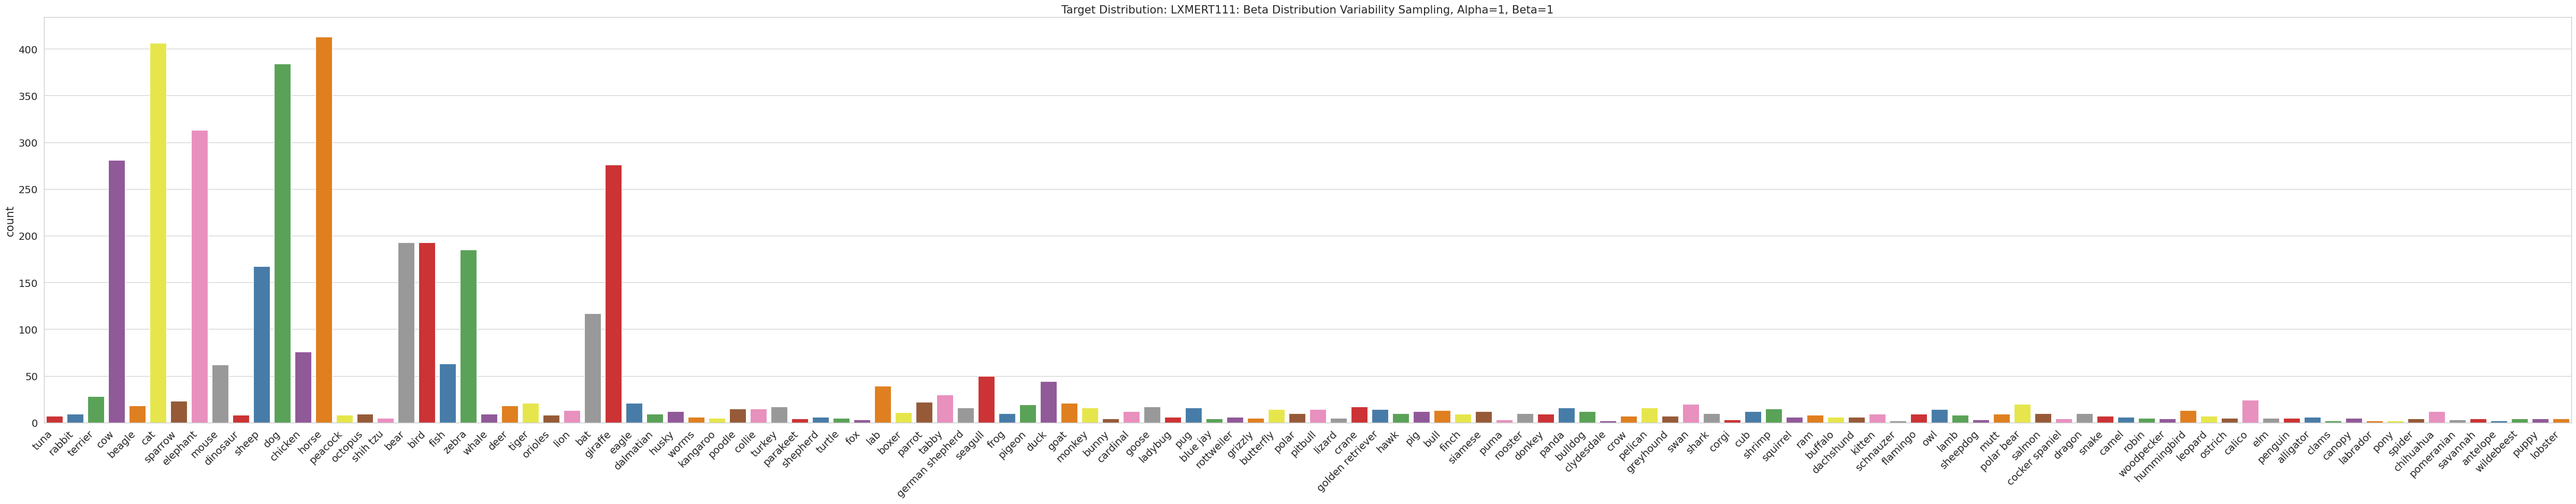

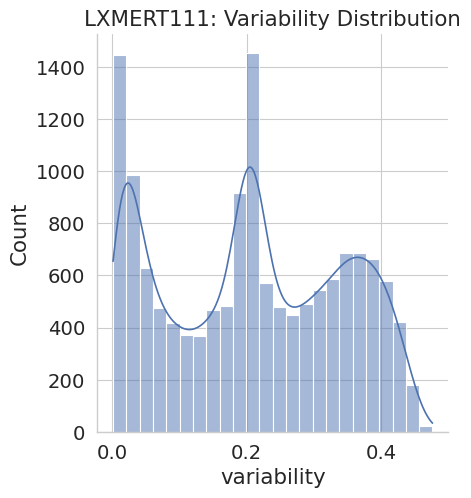

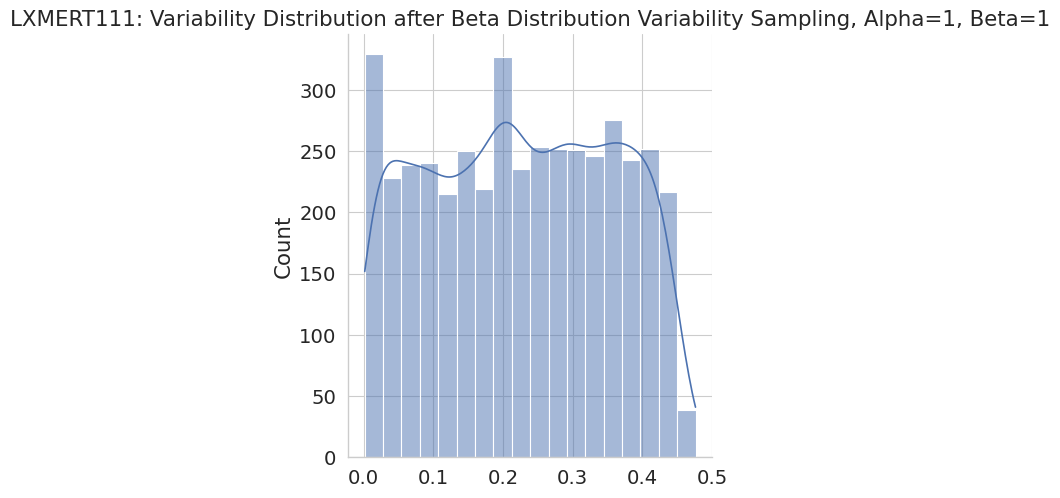

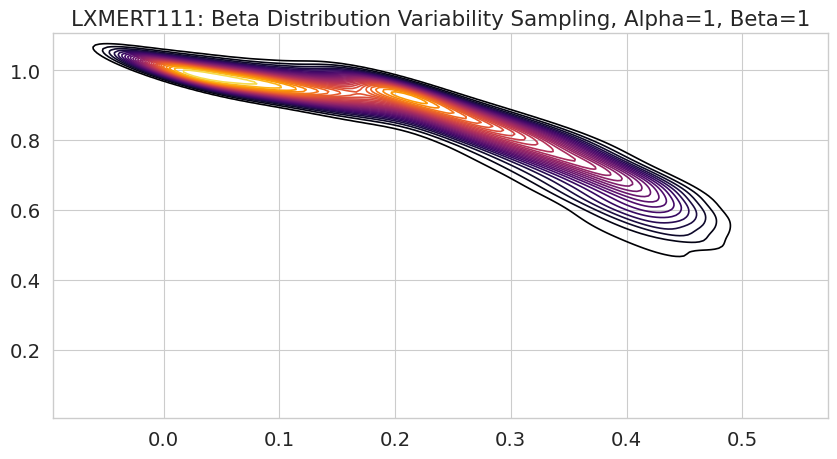

unique targets beta:  123
samples - beta:  4314
all samples- beta sampling:  14368


In [51]:
base_path ='../snap/vqa/vqa_lxr111_animals_fromScratch_20epochs_breeds/'
model = 'LXMERT111'
training_budget = 30
df = pd.read_pickle(base_path+"datamap_metrics.pkl")
ids = beta_sampling_reweight_counts(base_path, df, 1, 1, model, training_budget, kernel='gaussian', bandwidth=0.01)

bandwidth:  0.14740789217214353


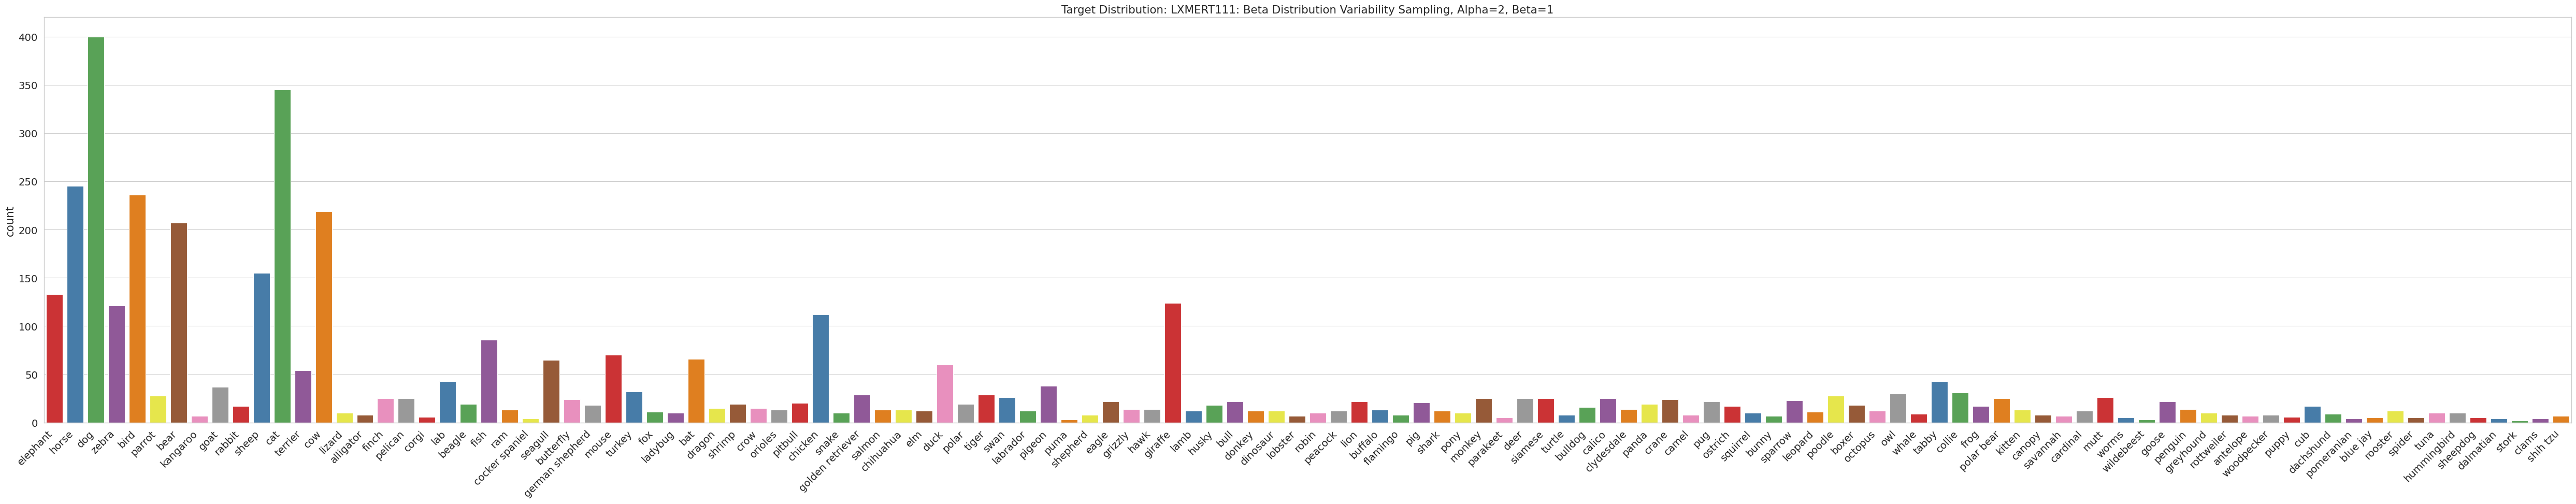

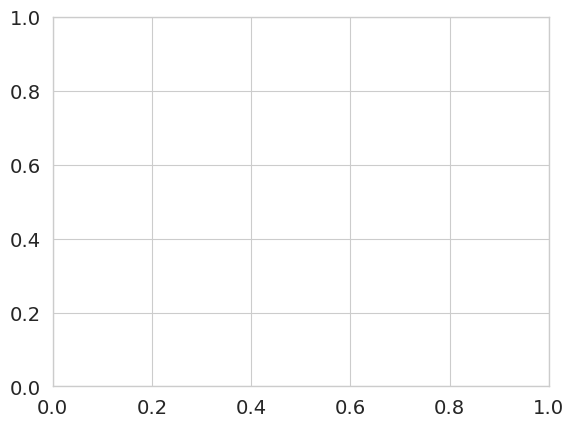

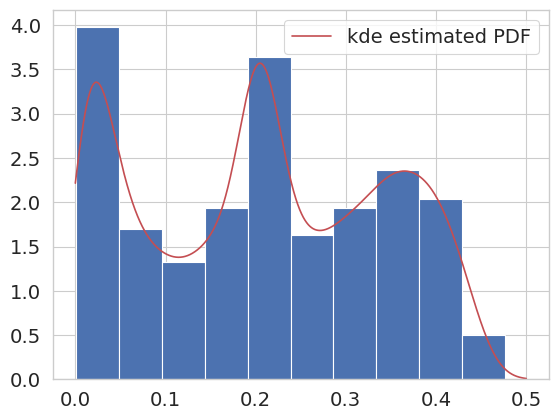

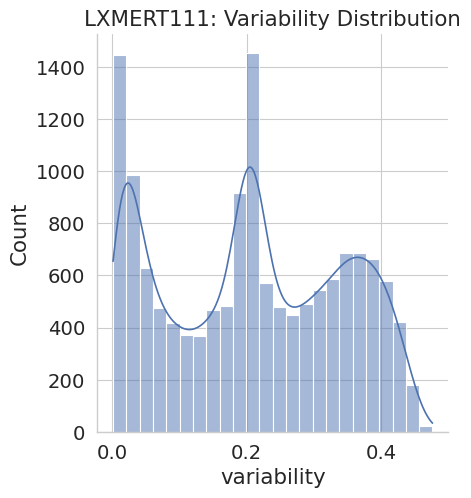

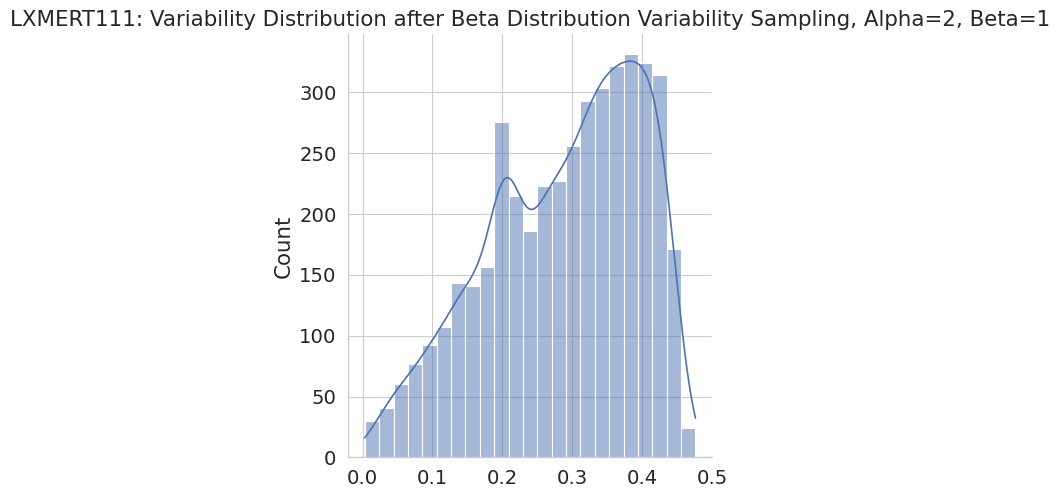

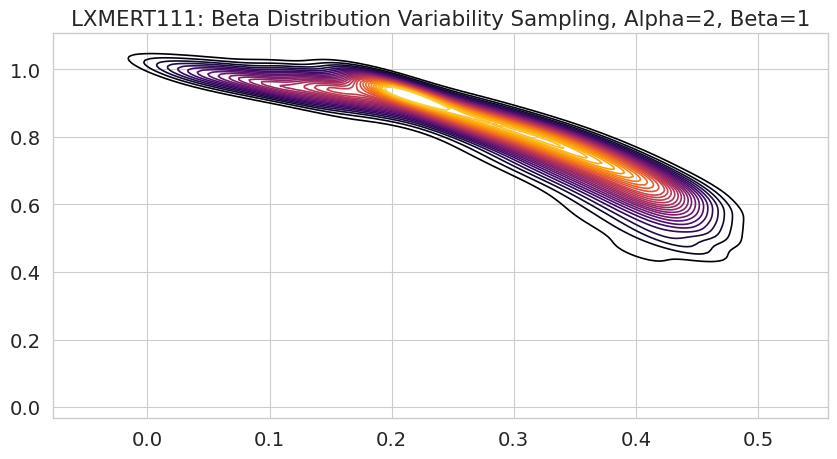

unique targets beta:  123
samples - beta:  4310
all samples- beta sampling:  14368


In [46]:
base_path ='../snap/vqa/vqa_lxr111_animals_fromScratch_20epochs_breeds/'
model = 'LXMERT111'
training_budget = 30
df = pd.read_pickle(base_path+"datamap_metrics.pkl")
ids = beta_sampling_reweight_counts(base_path, df, 2, 1, model, training_budget, kernel='gaussian_kde')

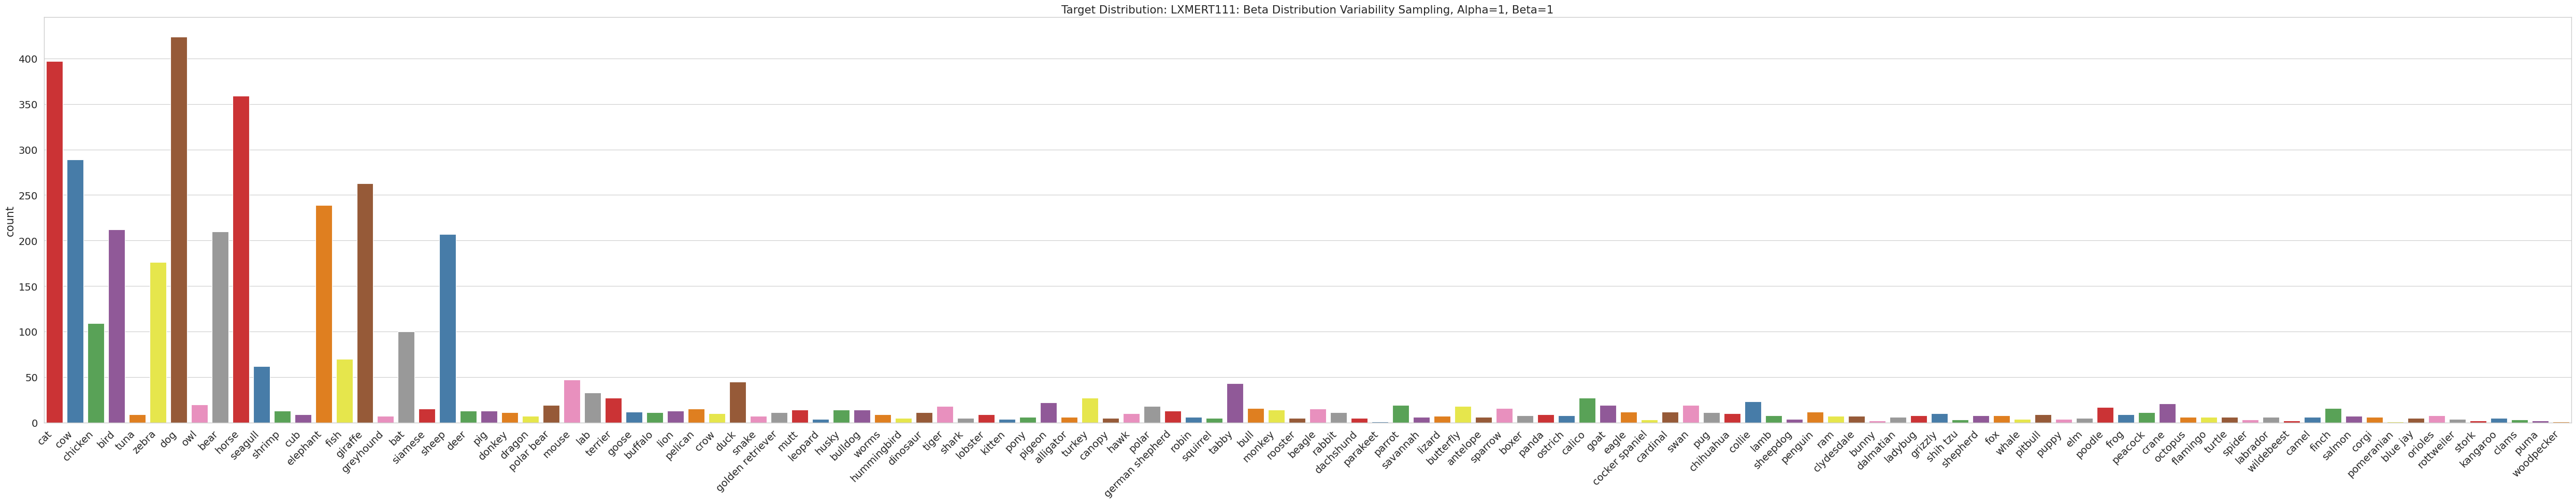

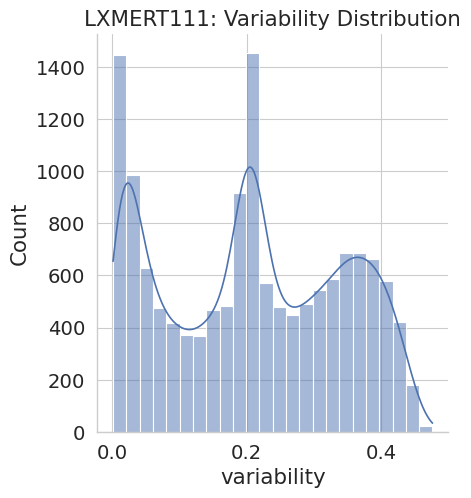

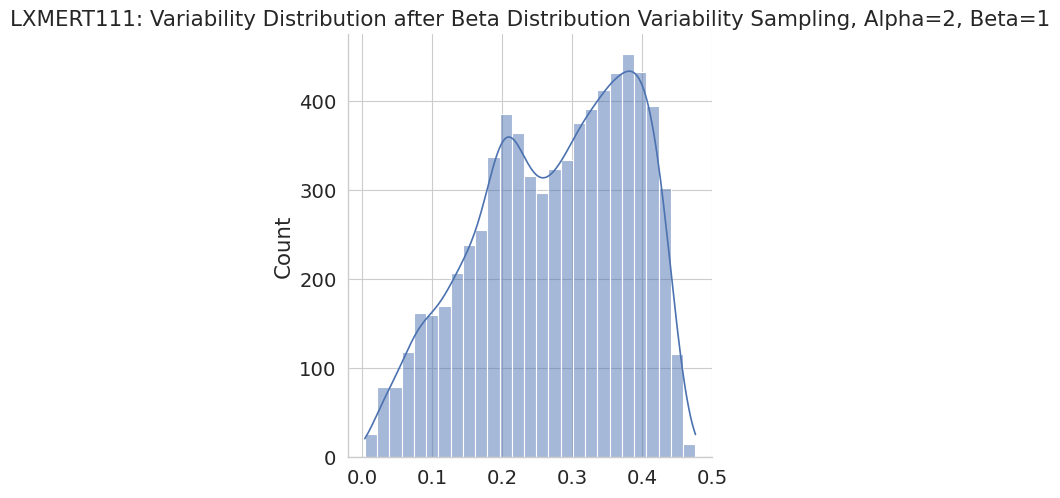

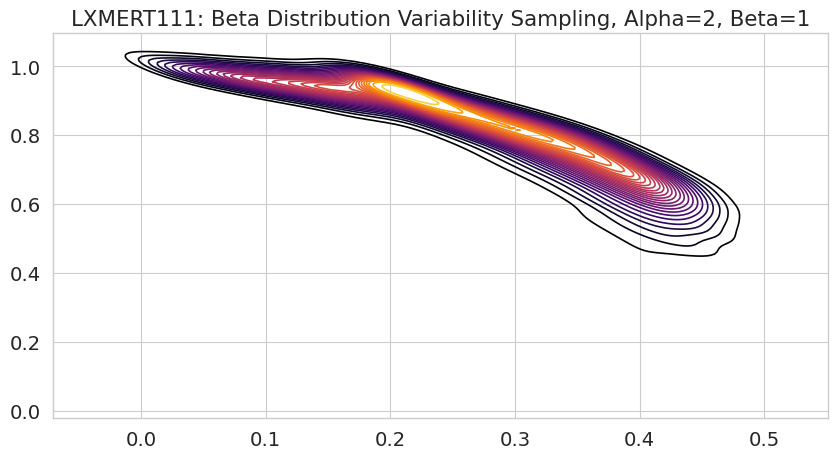

unique targets beta:  123
samples - beta:  7184
all samples- beta sampling:  14368


In [52]:
base_path ='../snap/vqa/vqa_lxr111_animals_fromScratch_20epochs_breeds/'
model = 'LXMERT111'
training_budget = 50
df = pd.read_pickle(base_path+"datamap_metrics.pkl")
ids = beta_sampling_reweight_counts(base_path, df, 2, 1, model, training_budget)

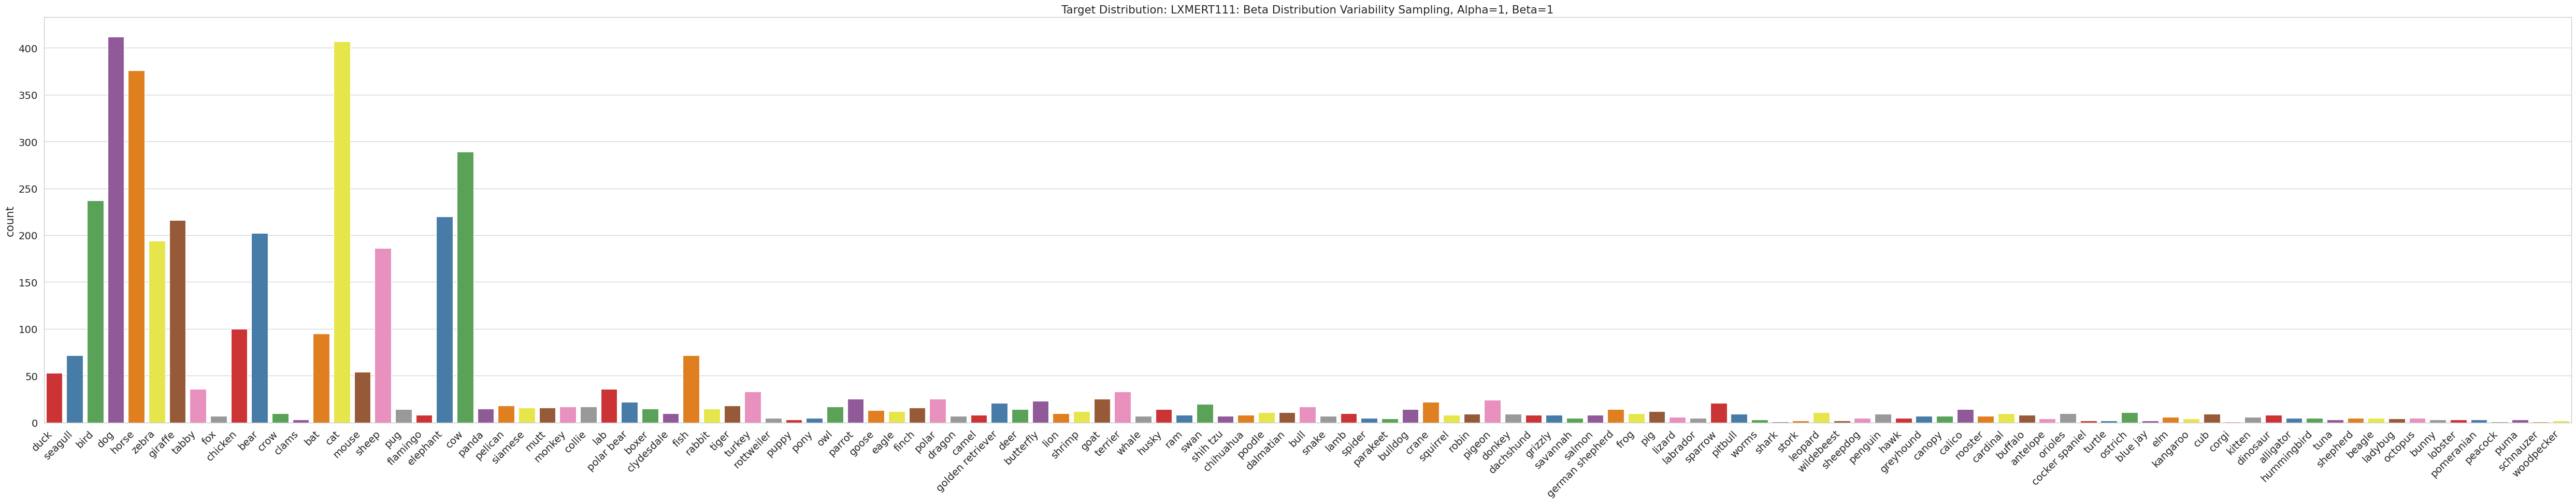

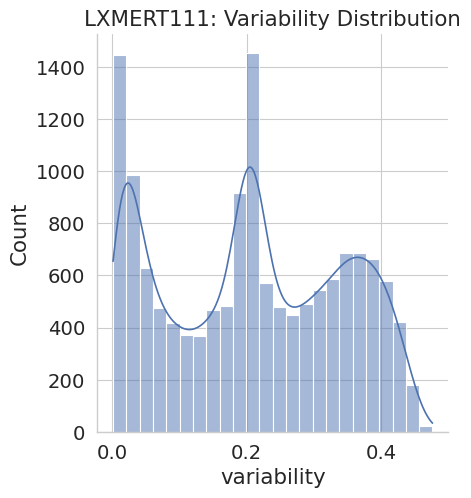

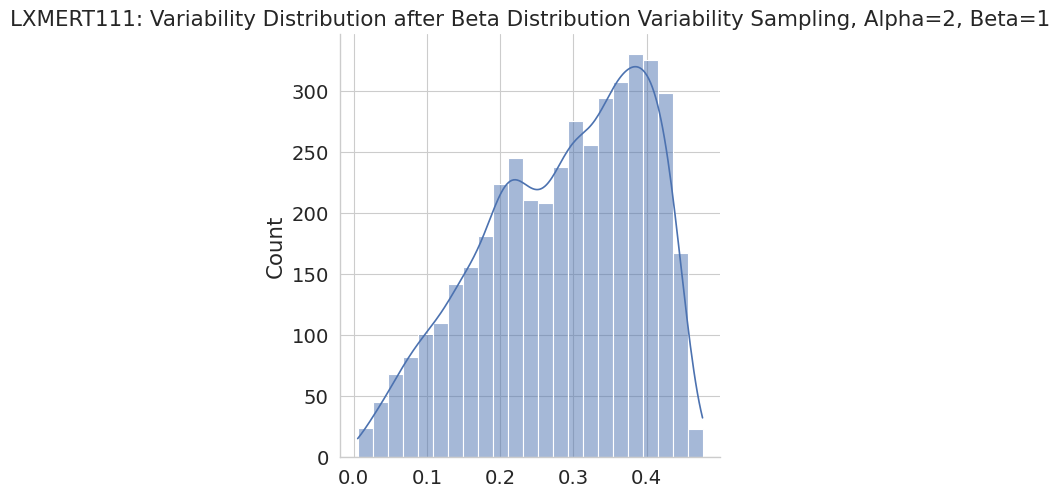

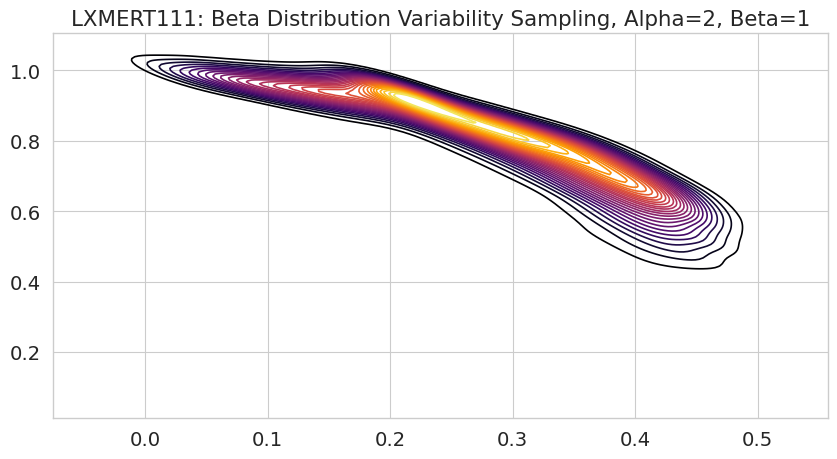

unique targets beta:  123
samples - beta:  4310
all samples- beta sampling:  14368


In [13]:
df = pd.read_pickle(base_path+"datamap_metrics.pkl")
ids = beta_sampling_reweight_counts(base_path, df, 2, 1, model, training_budget)

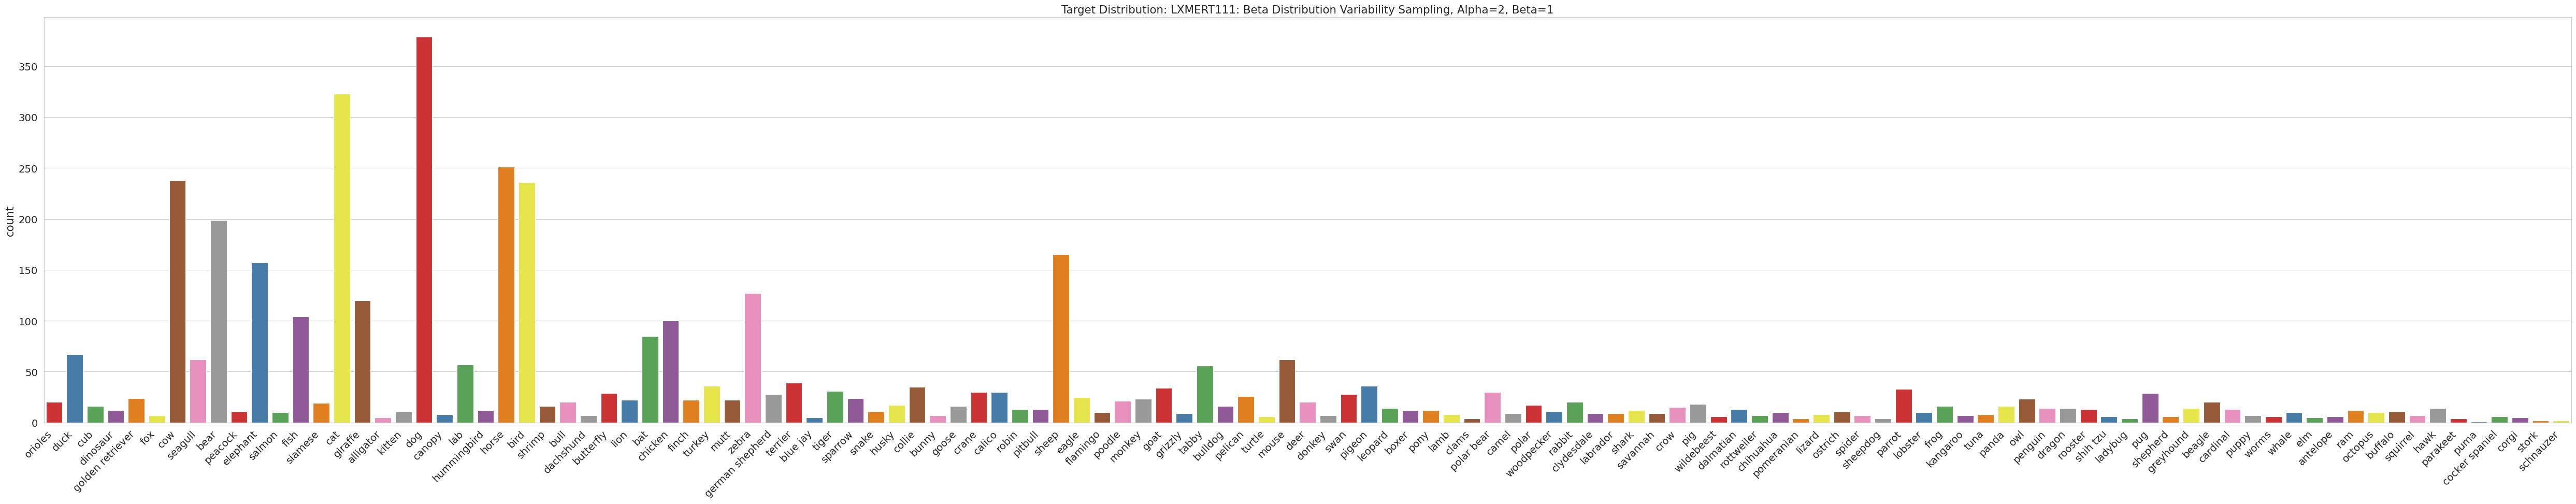

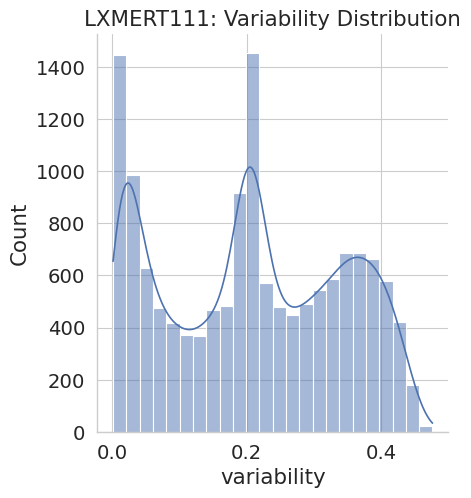

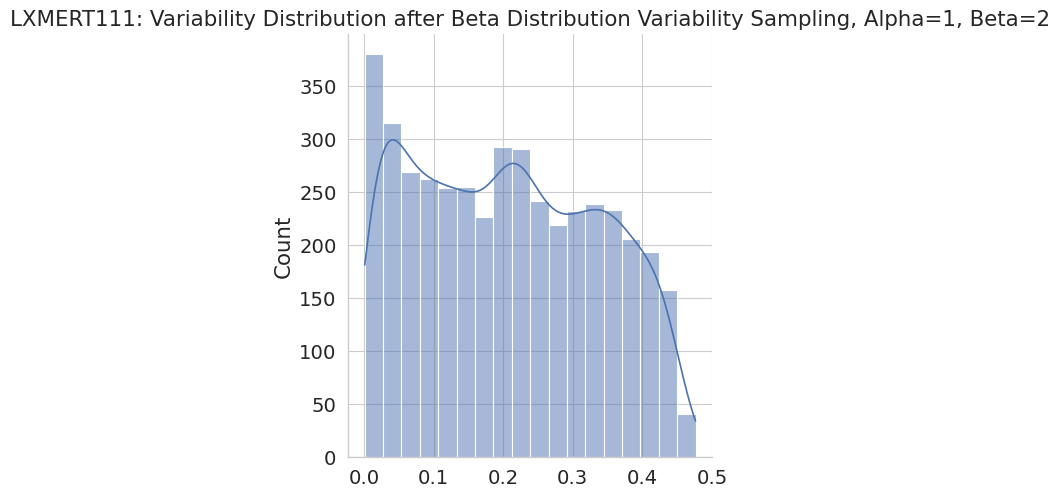

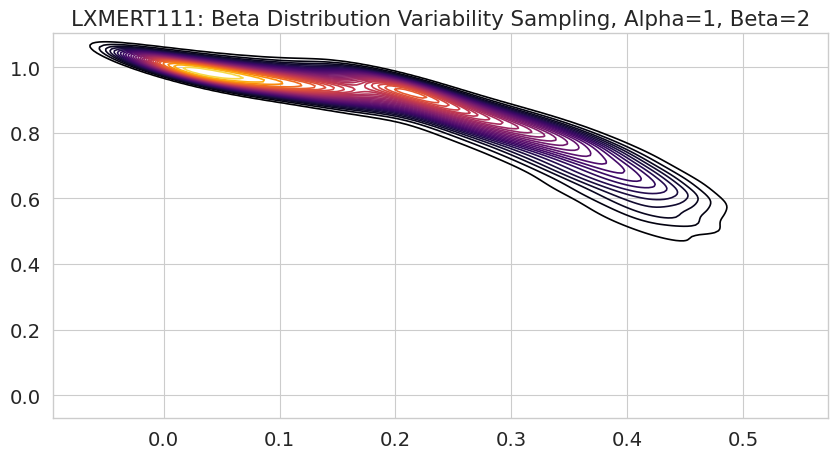

unique targets beta:  123
samples - beta:  4310
all samples- beta sampling:  14368


In [14]:
df = pd.read_pickle(base_path+"datamap_metrics.pkl")
ids = beta_sampling_reweight_counts(base_path, df, 1, 2, model, training_budget)

In [63]:
base_path ='../snap/vqa/vqa_lxr111_animals_fromScratch_20epochs_breeds/'
model = 'LXMERT111'
training_budget = 30
df = pd.read_pickle(base_path+"datamap_metrics.pkl")
ids = class_sampling(base_path, df, model, training_budget)

In [ ]:
base_path ='../snap/vqa/vqa_lxr955_animals_fromScratch_20epochs_breeds/'
df = pd.read_pickle(base_path+"datamap_metrics.pkl")
generate_class_variability_distributions(base_path, df)

base_path ='../snap/vqa/vqa_lxr111_animals_fromScratch_20epochs_breeds/'
df = pd.read_pickle(base_path+"datamap_metrics.pkl")
generate_class_variability_distributions(base_path, df)

In [ ]:
def generate_samples(base_path, model, training_budget):
    df = pd.read_pickle(base_path+"datamap_metrics.pkl")
    ids = class_sampling(base_path, df, model, training_budget)

    #calc_datamap_metrics(base_path)
    # df = pd.read_pickle(base_path+"datamap_metrics.pkl")
    # ids = variability_sampling(base_path, df, model, training_budget)

    # #calc_datamap_metrics(base_path)
    df = pd.read_pickle(base_path+"datamap_metrics.pkl")
    ids = target_distribution_variability_sampling(base_path, df, 1, 1, model, training_budget)

    # #calc_datamap_metrics(base_path)
    df = pd.read_pickle(base_path+"datamap_metrics.pkl")
    ids = target_distribution_variability_sampling(base_path, df, 2, 1, model, training_budget)

    # #calc_datamap_metrics(base_path)
    df = pd.read_pickle(base_path+"datamap_metrics.pkl")
    ids = target_distribution_variability_sampling(base_path, df, 1, 2, model, training_budget)

    df = pd.read_pickle(base_path+"datamap_metrics.pkl")
    ids = target_distribution_variability_sampling(base_path, df, 2, 2, model, training_budget)

    df = pd.read_pickle(base_path+"datamap_metrics.pkl")
    ids = random_sampling(base_path, df, model, training_budget)

In [ ]:
base_path ='../snap/vqa/vqa_lxr111_animals_fromScratch_20epochs_breeds/'
model = 'LXMERT111'
training_budget = 30
generate_samples(base_path, model, training_budget)